In [138]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [139]:
df = pd.read_csv("monthly_all_cust.csv")

enc = LabelEncoder()
df["season"] = enc.fit_transform(df["season"])
df["next months season"] = enc.fit_transform(df["next months season"])

df["Date"] = df["year"].astype(str)+"-"+df["month"].astype(str)
df["Date"] = pd.to_datetime(df["Date"])
df['Date']=df['Date'] + pd.offsets.MonthEnd(0)
df["item"] = 1

df = df.fillna(0)

df = df.set_index("Date")
df_train = df.loc["2017-01":"2022-06"]
df_pred = df["2022-07":"2022-12"]

df = df.reset_index()
df_train = df_train.reset_index()
df_pred = df_pred.reset_index()

print(df.shape)
print(df_train.shape)
print(df_pred.shape)

# display(df.tail())

(190, 68)
(66, 68)
(6, 68)


In [140]:
next_list = [col for col in df.columns if "next" in col]
features = [col for col in df.columns if col not in next_list]

next_features = ['next months expired investment', 'next months season', 'next month no of holidays', 
                 'next month no of weekends', 'next month no of business days', 'next month no of expired investment']

features = features + next_features
print(next_list)
print(features)

print(len(df.columns))
print(len(next_list))
print(len(features))

['next months expired investment', 'next months season', 'next months investment', 'next month no of holidays', 'next month no of weekends', 'next month no of business days', 'next month no of new investment', 'next month no of expired investment', 'next month no of new customer', 'next month no of retained customer', 'next month no of returned customer', 'next month no of churned customer']
['Date', 'year', 'month', 'no of new investment', 'no of new customer', 'no of retained customer', 'no of returned customer', 'no of churned customer', 'new cust investment', 'retained cust investment', 'returned cust investment', 'churned cust investment', 'new cust PSC', 'retained cust PSC', 'returned cust PSC', 'churned cust PSC', 'new cust default_amount', 'retained cust default_amount', 'returned cust default_amount', 'churned cust default_amount', 'current months expired investment', 'no of expired investment', 'current months investment', 'issued MemberID', 'expired MemberID', 'previous mont

In [141]:
# df[["next months investment"]].describe()

In [142]:
train_data = TimeSeriesDataFrame.from_data_frame(df_train[features+["next months investment"]], 
                                                 id_column="item", 
                                                 timestamp_column="Date")

display(train_data.head())
print(train_data.shape)

year  month  no of new investment  no of new customer  \
item_id timestamp                                                           
1       2017-01-31  2017      1                    27                   6   
        2017-02-28  2017      2                    14                   5   
        2017-03-31  2017      3                    19                   5   
        2017-04-30  2017      4                    21                   7   
        2017-05-31  2017      5                    29                   8   

                    no of retained customer  no of returned customer  \
item_id timestamp                                                      
1       2017-01-31                     20.0                      1.0   
        2017-02-28                      8.0                      1.0   
        2017-03-31                     10.0                      4.0   
        2017-04-30                     12.0                      4.0   
        2017-05-31                     14.0                      7.0   

                    no of churned customer  new cust investment  \
item_id timestamp                                                 
1       2017-01-31                     4.0             880000.0   
        2017-02-28                     4.0            1450000.0   
        2017-03-31                     3.0            1350000.0   
        2017-04-30                     4.0            1050000.0   
        2017-05-31                     5.0            1300000.0   

                    retained cust investment  returned cust investment  ...  \
item_id timestamp                                                       ...   
1       2017-01-31                 8180000.0                10000000.0  ...   
        2017-02-28                 2920000.0                  300000.0  ...   
        2017-03-31                 2820000.0                 1500000.0  ...   
        2017-04-30                 6420000.0                 1300000.0  ...   
        2017-05-31                 3090000.0                  810000.0  ...   

                    pct growth retained cust default_amount  \
item_id timestamp                                             
1       2017-01-31                                 3.435664   
        2017-02-28                                -0.946965   
        2017-03-31                                 2.393282   
        2017-04-30                                -0.637319   
        2017-05-31                                 9.492754   

                    pct growth returned cust default_amount  \
item_id timestamp                                             
1       2017-01-31                                -1.000000   
        2017-02-28                                 0.000000   
        2017-03-31                                 0.000000   
        2017-04-30                                -0.953738   
        2017-05-31                                 8.649390   

                    pct growth churned cust default_amount  \
item_id timestamp                                            
1       2017-01-31                               -0.822019   
        2017-02-28                               -0.000849   
        2017-03-31                               -1.000000   
        2017-04-30                                0.000000   
        2017-05-31                                0.000000   

                    next months expired investment  next months season  \
item_id timestamp                                                        
1       2017-01-31                       3980000.0                   2   
        2017-02-28                       8250000.0                   1   
        2017-03-31                       4850000.0                   1   
        2017-04-30                      17700000.0                   1   
        2017-05-31                       6210000.0                   0   

                    next month no of holidays  next month no of weekends  \
item_id timestamp                    

(66, 61)


In [143]:
predictor = TimeSeriesPredictor(
    prediction_length=6,
    path="autogluon-m4-hourly",
    target="next months investment",
    eval_metric="sMAPE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=300,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 10,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'prediction_length': 6,
 'random_seed': None,
 'target': 'next months investment',
 'time_limit': 300}
Provided training data set with 66 rows, 1 items (item = single time series). Average time series length is 66.0.
Training artifacts will be saved to: C:\Users\shahi\Downloads\Single Branch\FinApp\autogluon-m4-hourly
AutoGluon will save models to autogluon-m4-hourly\
AutoGluon will gauge predictive performance using evaluation metric: 'sMAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dat

  0%|          | 0/10 [00:00<?, ?it/s]

	cannot import name 'get_spawning_popen' from 'joblib.externals.loky.backend.context' (C:\ProgramData\Anaconda3\envs\idareAI\lib\site-packages\joblib\externals\loky\backend\context.py)
	cannot import name 'get_spawning_popen' from 'joblib.externals.loky.backend.context' (C:\ProgramData\Anaconda3\envs\idareAI\lib\site-packages\joblib\externals\loky\backend\context.py)
Stopping HPO due to exhausted search space: 2 of 2 possible configs ran.
	Trained 0 models while tuning Theta.
Hyperparameter tuning model: ARIMA. Tuning model for up to 27.27s of the 299.99s remaining.
	cannot import name 'get_spawning_popen' from 'joblib.externals.loky.backend.context' (C:\ProgramData\Anaconda3\envs\idareAI\lib\site-packages\joblib\externals\loky\backend\context.py)
Hyperparameter tuning model: AutoETS. Tuning model for up to 27.27s of the 299.99s remaining.
	-0.3617       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Hyperparameter tuning 

  0%|          | 0/10 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
	Trained 1 models while tuning DeepAR.
	-0.3629       = Validation score (-sMAPE)
	27.95   s     = Total tuning time
Hyperparameter tuning model: AutoARIMA. Tuning model for up to 27.27s of the 299.99s remaining.
	-0.4744       = Validation score (-sMAPE)
	0.01    s     = Training runtime
	0.15    s     = Validation (prediction) runtime
Hyperparameter tuning model: TemporalFusionTransformer. Tuning model for up to 27.27s of the 299.99s remaining.
	-0.3660       = Validation score (-sMAPE)
	29.52   s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Hyperparameter tuning model: SimpleFeedForward. Tuning model for up to 27.27s of the 299.99s remaining.


  0%|          | 0/10 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
	Trained 1 models while tuning SimpleFeedForward.
	-0.3740       = Validation score (-sMAPE)
	27.49   s     = Total tuning time
Fitting simple weighted ensemble.
	-0.3411       = Validation score (-sMAPE)
	1.83    s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training complete. Models trained: ['AutoETS', 'DynamicOptimizedTheta', 'DeepAR\\T1', 'AutoARIMA', 'TemporalFusionTransformer', 'SimpleFeedForward\\T1', 'WeightedEnsemble']
Total runtime: 87.80 s
Best model: WeightedEnsemble
Best model score: -0.3411


In [144]:
predictions = predictor.predict(train_data).reset_index()
display(predictions)
print(predictions.shape)

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


,item_id,timestamp,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,2022-07-31,20097372.0,10469421.0,14447901.0,16592808.0,18210198.0,19494704.0,21690290.0,23639608.0,25648992.0,29804468.0
1,1,2022-08-31,22745044.0,14379241.0,17844670.0,19458908.0,21262544.0,22725284.0,24242780.0,26791798.0,28924956.0,32931780.0
2,1,2022-09-30,26308964.0,16945386.0,21190824.0,23732010.0,24912988.0,26250604.0,27764662.0,29052096.0,31116570.0,35620156.0
3,1,2022-10-31,27242998.0,19749008.0,22440772.0,24243602.0,26125944.0,27408112.0,28972396.0,30505356.0,32278298.0,36350156.0
4,1,2022-11-30,27190454.0,19892708.0,22133086.0,24096108.0,26090172.0,27260112.0,28881224.0,30525786.0,32565110.0,35955340.0
5,1,2022-12-31,27747900.0,16669851.0,21059198.0,23575524.0,25700020.0,27653800.0,29548888.0,31461874.0,34554948.0,38676204.0


(6, 12)


In [145]:
# predictions.info()
train_data = train_data.reset_index()

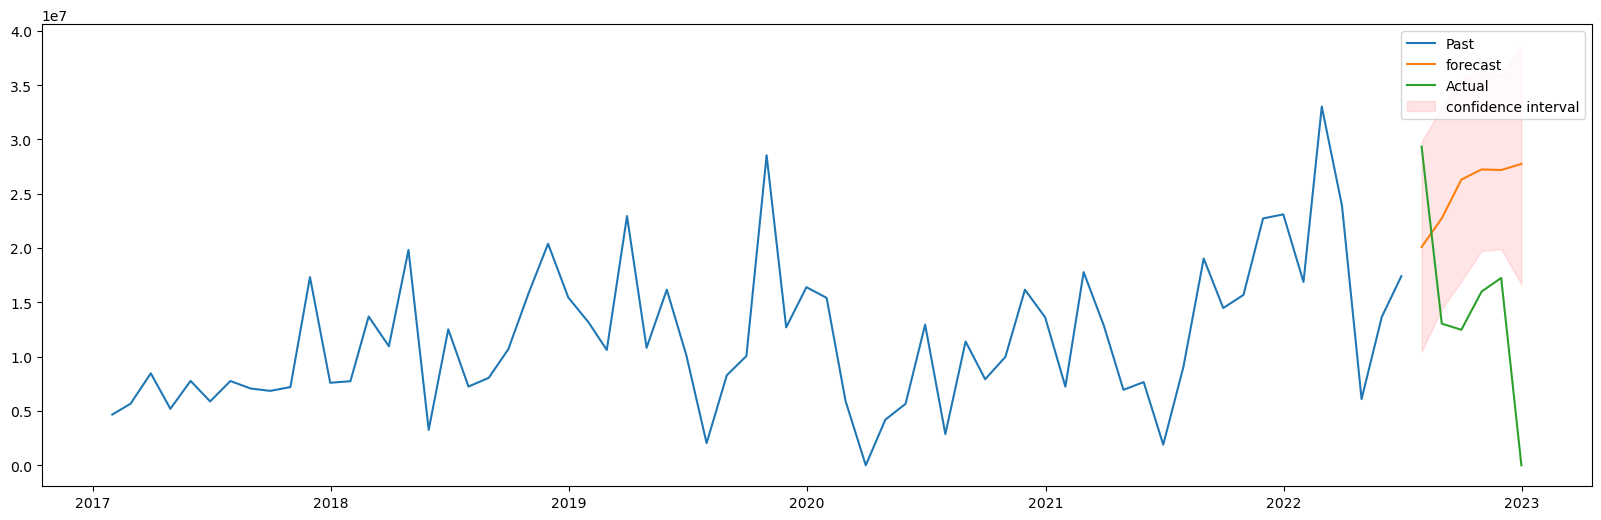

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(train_data["timestamp"], train_data["next months investment"], label="Past")
plt.plot(predictions["timestamp"], predictions["mean"], label="forecast")
plt.plot(df_pred["Date"], df_pred["next months investment"], label="Actual")

plt.fill_between(predictions["timestamp"], 
                 predictions["0.1"], 
                 predictions["0.9"], 
                 color="red", 
                 alpha=0.1, 
                 label=f"confidence interval")
plt.legend();